In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(formatter={'float_kind': "{:.2f}".format})
%config InlineBackend.figure_format = 'svg'

In [2]:
path = '/home/arthur/Project/GeekBrains/DB_research/!ADDS/hw_7/orders_all.csv'

In [3]:
df = pd.read_csv(path, sep=';')
df.head()

,id_order,id_user,price,o_date
0,129,1,1337,26.04.2013
1,130,155,182,26.04.2013
2,131,1,602,26.04.2013
3,132,1,863,26.04.2013
4,133,1,2261,29.04.2013


In [4]:
df.describe()

,id_order,id_user,price
count,4365731.00,4365731.00,4365731.00
mean,5147334.17,3325856.20,1603399222.39
std,3509188.80,3011275.40,3350190892904.72
min,129.00,0.00,-2086.00
25%,1812644.00,588094.00,734.00
50%,5040464.00,2333255.00,1386.00
75%,8403741.00,5422811.00,2496.00
max,16970584.00,9900289.00,7000000000000000.00


In [5]:
# задание соответствующих форматов столбцам
# убираем 00.00.000 и заполняем предыдущей датой (строки идут по порядку)
df.loc[df['o_date']=='00.00.0000', 'o_date'] = np.nan
df.loc[:, 'o_date'] = df.loc[:, 'o_date'].fillna(method='ffill')

df['o_date'] = pd.to_datetime(df['o_date'], format='%d.%m.%Y')
df['year'] = df['o_date'].dt.year
df['month'] = df['o_date'].dt.month
# df['price'] = df['price'].str.replace(',', '.').astype('float')

In [6]:
# убираем выбросы
index_to_drop = df.loc[df['price']>10000000].index
index_to_drop
df.drop(index=index_to_drop, inplace=True)
df.loc[df['price']<0, 'price'] = -df.loc[df['price']<0, 'price']

In [7]:
df.describe()

,id_order,id_user,price,year,month
count,4365730.00,4365730.00,4365730.00,4365730.00,4365730.00
mean,5147335.35,3325856.96,2219.69,2016.70,7.45
std,3509188.34,3011275.32,3492.28,1.25,3.55
min,129.00,0.00,0.00,2013.00,1.00
25%,1812645.75,588094.00,734.00,2016.00,4.00
50%,5040464.50,2333255.00,1386.00,2017.00,8.00
75%,8403742.50,5422811.50,2496.00,2018.00,11.00
max,16970584.00,9900289.00,1679500.00,2018.00,12.00


In [8]:
df.head()

,id_order,id_user,price,o_date,year,month
0,129,1,1337,2013-04-26,2013,4
1,130,155,182,2013-04-26,2013,4
2,131,1,602,2013-04-26,2013,4
3,132,1,863,2013-04-26,2013,4
4,133,1,2261,2013-04-29,2013,4


# Карта поведения пользователей.
**Всех пользователей можно разделить:**
- на New (совершили только 1 покупку), 
- Regular (совершили 2 или более), 
- Vip (совершили дорогие покупки и достаточно часто), 
- Lost (раньше покупали хотя бы раз и с даты последней покупки прошло больше 3 месяцев).

### 1. Уточнить критерии групп New,Regular,Vip,Lost

In [9]:
df_pivot = df.pivot_table(index=['id_user'], values=['id_order', 'o_date', 'price'], \
        aggfunc={'id_order': 'count', 'o_date': 'max', 'price': ['mean', 'sum']})
df_pivot.columns = ['o_count', 'max_o_date', 'o_mean', 'o_sum']
# df_pivot['date_delta'] = np.datetime64('2018-12-31') - df_pivot['max_o_date']
df_pivot

,o_count,max_o_date,o_mean,o_sum
id_user,,,,
0,161,2016-12-08,2162.38,348143.00
1,50,2017-08-01,2267.78,113389.00
19,1,2018-06-02,5774.00,5774.00
39,3,2014-08-27,2100.00,6300.00
44,1,2013-05-16,966.00,966.00
...,...,...,...,...
9900265,1,2018-12-26,3359.00,3359.00
9900275,1,2018-12-27,696.00,696.00
9900283,1,2018-12-27,1008.00,1008.00


In [10]:
# проставляем группы в 'marker'
dates = ['2017-01-01', '2017-02-01', '2017-03-01']

for ind, d in enumerate(dates):
    ind += 1
    ind = str(ind)
    
    # проставляем целевую дату и считаем от нее все
    df_pivot['date_delta'+ind] = np.datetime64(d) - df_pivot['max_o_date']
    
    # сначала отсекаем лишних
    df_pivot.loc[df_pivot['date_delta'+ind] > np.timedelta64('90', 'D'), 'marker'+ind] = 'lost'

    # первичное проставление випов
    df_pivot.loc[
        (df_pivot['marker'+ind].isnull()) & 
        (df_pivot['o_mean'] > 3500) & 
        (df_pivot['o_count'] > 3), 'marker'+ind] = 'vip'

    # проставляем новых
    df_pivot.loc[
        (df_pivot['marker'+ind].isnull()) & 
        (df_pivot['o_count'] == 1), 'marker'+ind] = 'new'

    # добираем випов
    df_pivot.loc[(df_pivot['marker'+ind].isnull()) & 
                (df_pivot['o_sum'] >= 10000) & 
                (df_pivot['o_count'] > 4), 'marker'+ind] = 'vip'

    # оставльные - обычные
    df_pivot.loc[(df_pivot['marker'+ind].isnull()), 'marker'+ind] = 'regular'

df_pivot

,o_count,max_o_date,o_mean,o_sum,date_delta1,marker1,date_delta2,marker2,date_delta3,marker3
id_user,,,,,,,,,,
0,161,2016-12-08,2162.38,348143.00,24 days,vip,55 days,vip,83 days,vip
1,50,2017-08-01,2267.78,113389.00,-212 days,vip,-181 days,vip,-153 days,vip
19,1,2018-06-02,5774.00,5774.00,-517 days,new,-486 days,new,-458 days,new
39,3,2014-08-27,2100.00,6300.00,858 days,lost,889 days,lost,917 days,lost
44,1,2013-05-16,966.00,966.00,1326 days,lost,1357 days,lost,1385 days,lost
...,...,...,...,...,...,...,...,...,...,...
9900265,1,2018-12-26,3359.00,3359.00,-724 days,new,-693 days,new,-665 days,new
9900275,1,2018-12-27,696.00,696.00,-725 days,new,-694 days,new,-666 days,new
9900283,1,2018-12-27,1008.00,1008.00,-725 days,new,-694 days,new,-666 days,new


### 2. По состоянию на 1.01.2017 понимаем, кто попадает в какую группу, подсчитываем кол-во пользователей в каждой.

In [11]:
df_pivot_1 = df_pivot.reset_index().pivot_table(index=['marker1'], values=['id_user'], aggfunc='count')
df_pivot_1

,id_user
marker1,
lost,540100
new,1211651
regular,295046
vip,99898


### 3. По состоянию на 1.02.2017 понимаем, кто вышел из каждой из групп, а кто вошел.

In [12]:
df_pivot_2 = df_pivot.reset_index().pivot_table(index=['marker2'], values=['id_user'], aggfunc='count')
df_pivot_2

,id_user
marker2,
lost,578014
new,1180624
regular,289270
vip,98787


### 4. Аналогично смотрим состояние на 1.03.2017, понимаем кто вышел из каждой из групп, а кто вошел.

In [13]:
df_pivot_3 = df_pivot.reset_index().pivot_table(index=['marker3'], values=['id_user'], aggfunc='count')
df_pivot_3

,id_user
marker3,
lost,628088
new,1138866
regular,282263
vip,97478


### 5. В итоге делаем вывод, какая группа уменьшается, какая увеличивается.

In [14]:
df_stat = df_pivot_1.reset_index().merge(df_pivot_2.reset_index(), left_on='marker1', right_on='marker2')
df_stat.columns = ['marker1', '01.01.2017', 'marker2', '01.02.2017']
df_stat = df_stat.merge(df_pivot_3.reset_index(), left_on='marker1', right_on='marker3')
df_stat.columns = ['marker1', '01.01.2017', 'marker2', '01.02.2017', 'marker3', '01.03.2017']
df_stat = df_stat[['marker1', '01.01.2017', '01.02.2017','01.03.2017']]
df_stat

,marker1,01.01.2017,01.02.2017,01.03.2017
0,lost,540100,578014,628088
1,new,1211651,1180624,1138866
2,regular,295046,289270,282263
3,vip,99898,98787,97478


In [15]:
# транспонируем для построения графика
df_stat_ = df_stat.T
df_stat_.columns = df_stat_.loc['marker1']
df_stat_.drop(index='marker1', inplace=True)
for i in df_stat_.columns:  # переводим значения принудительно в числа
    df_stat_.loc[:, i] = df_stat_.loc[:, i].astype('int64')
df_stat_

marker1,lost,new,regular,vip
01.01.2017,540100,1211651,295046,99898
01.02.2017,578014,1180624,289270,98787
01.03.2017,628088,1138866,282263,97478


<AxesSubplot:>

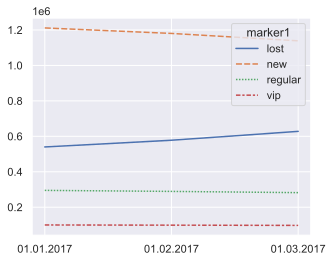

In [16]:
sns.set_theme()
plt.figure(figsize=(5, 4))
#sns.lineplot(data=trend, x='yymm', y='price')
sns.lineplot(data=df_stat_)